# Summary 

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
recording from these individuals ("name" column). The main aim of the data 
is to discriminate healthy people from those with PD, according to "status" 
column which is set to 0 for healthy and 1 for PD, i.e. this is a binary classfication problem. The test should have at maximum a False Negative Rate of 0.1%, that is the test sensitivity should be high, at least 0.9% as it is more important to correctly identify patients with the disease. 

----------------

Cited References:-

Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 
'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', 
IEEE Transactions on Biomedical Engineering (to appear).

'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 

----------
# Data Wrangling
-------------

In [8]:
# Load Necessary Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import seaborn as sns
import matplotlib.pyplot as plt

seed = 123

In [9]:
df = pd.read_csv('./parkinsons.data', sep=',')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [10]:
df.shape

(195, 24)

In [11]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [12]:
data = df.rename({'MDVP:Fo(Hz)':'fo', 'MDVP:Fhi(Hz)':'fhi', 'MDVP:Flo(Hz)':'flo', 'MDVP:Jitter(%)':'jitter',
       'MDVP:Jitter(Abs)':'jitter_abs', 'MDVP:RAP':'RAP', 'MDVP:PPQ':'PPQ', 'Jitter:DDP':'DDP',
       'MDVP:Shimmer':'shimmer', 'MDVP:Shimmer(dB)':'shimmer_db', 'Shimmer:APQ3':'APQ3', 
        'Shimmer:APQ5':'APQ5', 'MDVP:APQ':'APQ', 'Shimmer:DDA':'DDA'}, axis = 1)

Renaming columns for ease of use

In [13]:
data.name.duplicated().sum()

0

No duplicated/rows copied twice by mistake found using 'name' feature

In [14]:
data = data.drop(columns = 'name')
data.shape

(195, 23)

Dropping 'name' featue as it contains no information relevant to our analysis

In [96]:
features = list(data.drop(columns = 'status').columns)
outcome = ['Healthy', 'PD']

In [97]:
data.isnull().sum()

fo            0
fhi           0
flo           0
jitter        0
jitter_abs    0
RAP           0
PPQ           0
DDP           0
shimmer       0
shimmer_db    0
APQ3          0
APQ5          0
APQ           0
DDA           0
NHR           0
HNR           0
status        0
RPDE          0
DFA           0
spread1       0
spread2       0
D2            0
PPE           0
dtype: int64

There are no missing or NA values

In [98]:
data.dtypes.value_counts()

float64    22
int64       1
dtype: int64

Data type are all float type except status which is outcome/response variable
As all explanatory variables are floats and there are no missing values, we can confirm there are no misspelled NA values either like missing values denoted by NAN, '-', 'Missing' etc.


In [99]:
round(data.describe(),5)

,fo,fhi,flo,jitter,jitter_abs,RAP,PPQ,DDP,shimmer,shimmer_db,...,DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,...,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000,195.00000
mean,154.22864,197.10492,116.32463,0.00622,0.00004,0.00331,0.00345,0.00992,0.02971,0.28225,...,0.04699,0.02485,21.88597,0.75385,0.49854,0.71810,-5.68440,0.22651,2.38183,0.20655
std,41.39006,91.49155,43.52141,0.00485,0.00003,0.00297,0.00276,0.00890,0.01886,0.19488,...,0.03046,0.04042,4.42576,0.43188,0.10394,0.05534,1.09021,0.08341,0.38280,0.09012
min,88.33300,102.14500,65.47600,0.00168,0.00001,0.00068,0.00092,0.00204,0.00954,0.08500,...,0.01364,0.00065,8.44100,0.00000,0.25657,0.57428,-7.96498,0.00627,1.42329,0.04454
25%,117.57200,134.86250,84.29100,0.00346,0.00002,0.00166,0.00186,0.00498,0.01650,0.14850,...,0.02474,0.00592,19.19800,1.00000,0.42131,0.67476,-6.45010,0.17435,2.09913,0.13745
50%,148.79000,175.82900,104.31500,0.00494,0.00003,0.00250,0.00269,0.00749,0.02297,0.22100,...,0.03836,0.01166,22.08500,1.00000,0.49595,0.72225,-5.72087,0.21888,2.36153,0.19405
75%,182.76900,224.20550,140.01850,0.00736,0.00006,0.00384,0.00396,0.01150,0.03788,0.35000,...,0.06080,0.02564,25.07550,1.00000,0.58756,0.76188,-5.04619,0.27923,2.63646,0.25298
max,260.10500,592.03000,239.17000,0.03316,0.00026,0.02144,0.01958,0.06433,0.11908,1.30200,...,0.16942,0.31482,33.04700,1.00000,0.68515,0.82529,-2.43403,0.45049,3.67116,0.52737


Typically fundamental frequencies lie roughly in the range 80 to 450 Hz, where males have lower voices than females and children. Looking at min max values, most seem to be in range. 

Note however there is no explanatory variable for sex and age and also other factors which can affect the outcome variable. A subject experts advice would defintely be required to assess the quality of the variables indepth especially when trying to determine the reason for outliers if any.

We further note, variables are not scaled and all features except 'spread1' are positive and some have very small values close to 0 as well.

In [100]:
data['status'].value_counts(normalize = True)

1    0.753846
0    0.246154
Name: status, dtype: float64

We observe that our data is moderately moderately imblanced. We have more people affected by Parkinsons disease than healthy people in our dataset.

# Splitting the Data
Before Proceeding further into Explortory Data Analysis, we will split our data to prevent data leakage.
Also we will use stratified shuffle split as our data is moderately imblanced, so to maintain the same ratio of predictor classes and randomize grouping of train/test groups to decrease correlation.

In [101]:
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state= seed)

train_idx, test_idx = next(strat_shuf_split.split(data[features], data.status))

# Create the dataframes
X_train = data.loc[train_idx, features]
y_train = data.loc[train_idx, 'status']

X_test  = data.loc[test_idx, features]
y_test  = data.loc[test_idx, 'status']

len(X_train), len(X_test)

(136, 59)

In [102]:
# Joining explanatory and outcome data to make it easier for us to perform EDA

Xy_train = pd.concat([X_train, y_train], axis = 1)
Xy_test = pd.concat([X_test, y_test], axis =1)

Xy_train.head()

,fo,fhi,flo,jitter,jitter_abs,RAP,PPQ,DDP,shimmer,shimmer_db,...,DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
146,169.774,191.759,151.451,0.01568,0.00009,0.00863,0.00946,0.02589,0.08143,0.821,...,0.11411,0.07530,12.359,0.561610,0.793509,-3.297668,0.414758,3.413649,0.457533,1
170,244.990,272.210,239.170,0.00451,0.00002,0.00279,0.00237,0.00837,0.01897,0.181,...,0.03253,0.01049,21.528,0.522812,0.646818,-7.304500,0.171088,2.095237,0.096220,0
182,149.818,163.417,144.786,0.00336,0.00002,0.00174,0.00198,0.00521,0.02145,0.198,...,0.03464,0.00595,23.008,0.329577,0.757180,-6.277170,0.109397,2.209021,0.156368,1
178,148.790,158.359,138.990,0.00309,0.00002,0.00152,0.00186,0.00456,0.01574,0.142,...,0.02518,0.00488,24.412,0.402591,0.762508,-6.311987,0.182459,2.251553,0.160306,1
104,154.003,160.267,128.621,0.00183,0.00001,0.00076,0.00100,0.00229,0.01030,0.094,...,0.01406,0.00243,28.409,0.263654,0.691483,-7.111576,0.144780,2.065477,0.093193,1


----------------------------
# Exploratory Data Analysis
----------------------------

# Histograms

/home/pulkit/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pulkit/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


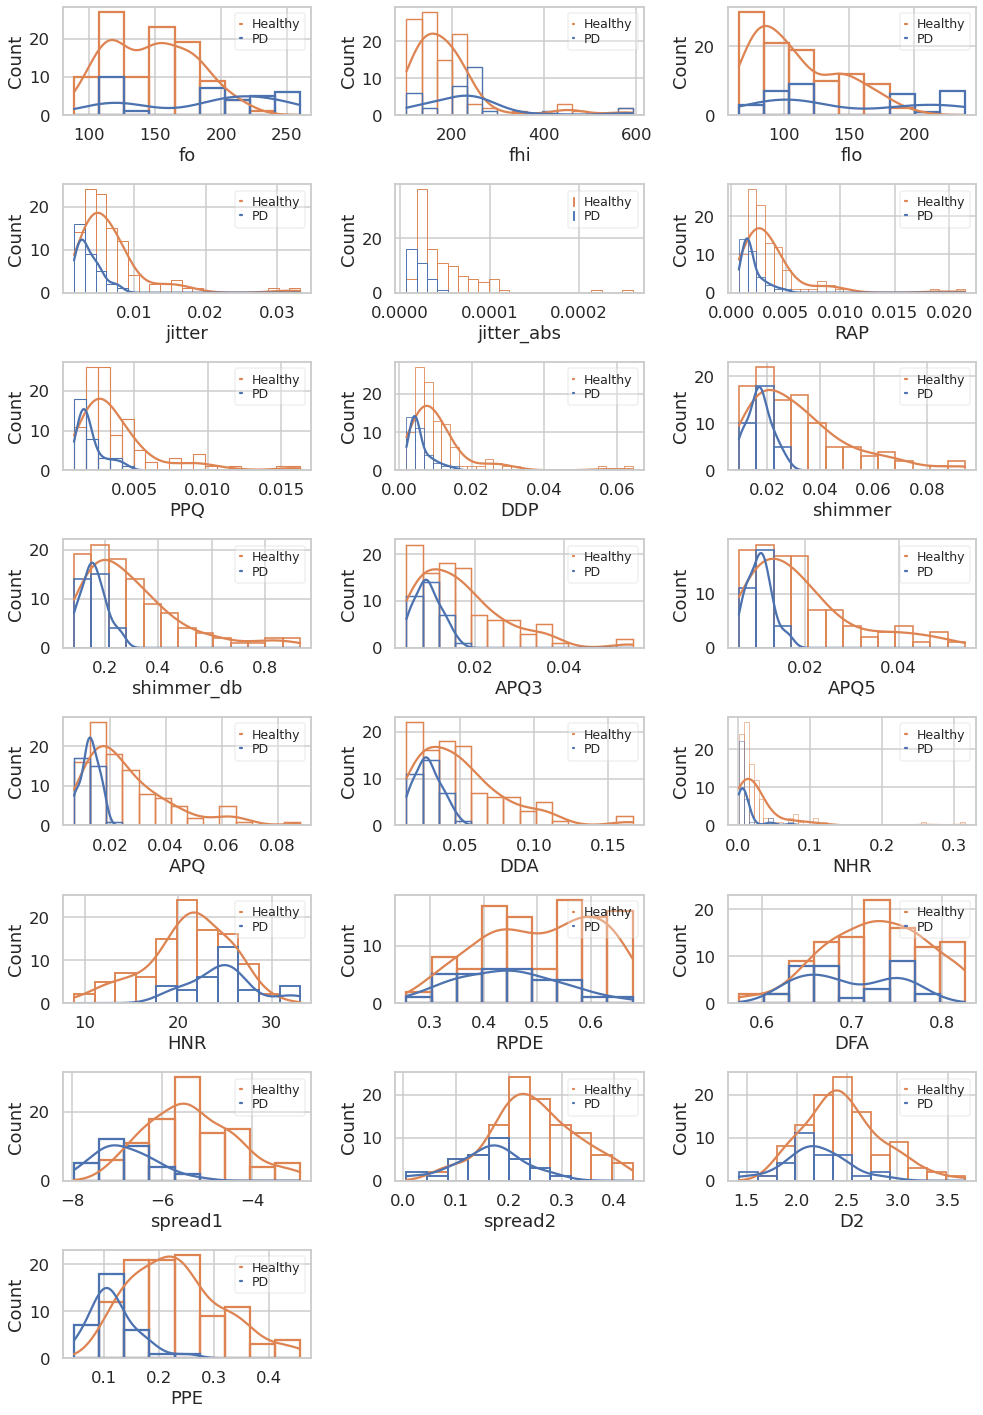

In [103]:
sns.set(font_scale=1)
sns.set_context("talk")
sns.set_style("whitegrid")

def histogram_eda(data):
    fig, ax = plt.subplots(8, 3, figsize=(14, 20))
    ax = ax.flatten()
    ax[-1].set_axis_off()
    ax[-2].set_axis_off()
    labels = ["Healthy", "PD"]
    for ax,feature in zip(ax,features):
        ax = sns.histplot(x = feature, ax = ax, hue = 'status', kde = True, fill=False, data = data,
                          legend = False)
        ax.legend(labels=labels,loc="upper right", framealpha= 0.3, fontsize = 'x-small', handlelength=0.1,
                  labelspacing=0.1)

    plt.tight_layout()
            
histogram_eda(Xy_train)

We plot histogram with respect to status and note that most of the variables are right skewed

In [104]:
# Calculating skewness of dataset

skew_limit = 0.75
skew_vals = Xy_train[features].skew()
skew_cols = skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending = False)
skew_cols_name = skew_cols.index.values

print(f"Columns skewed more than 0.75: {skew_cols_name}")

Columns skewed more than 0.75: ['NHR' 'DDP' 'RAP' 'jitter' 'jitter_abs' 'PPQ' 'fhi' 'APQ' 'shimmer_db'
 'DDA' 'APQ3' 'shimmer' 'APQ5' 'flo']


The same is confirmed by skewtest and we get the list of features skewed more than 0.75

# Boxplots

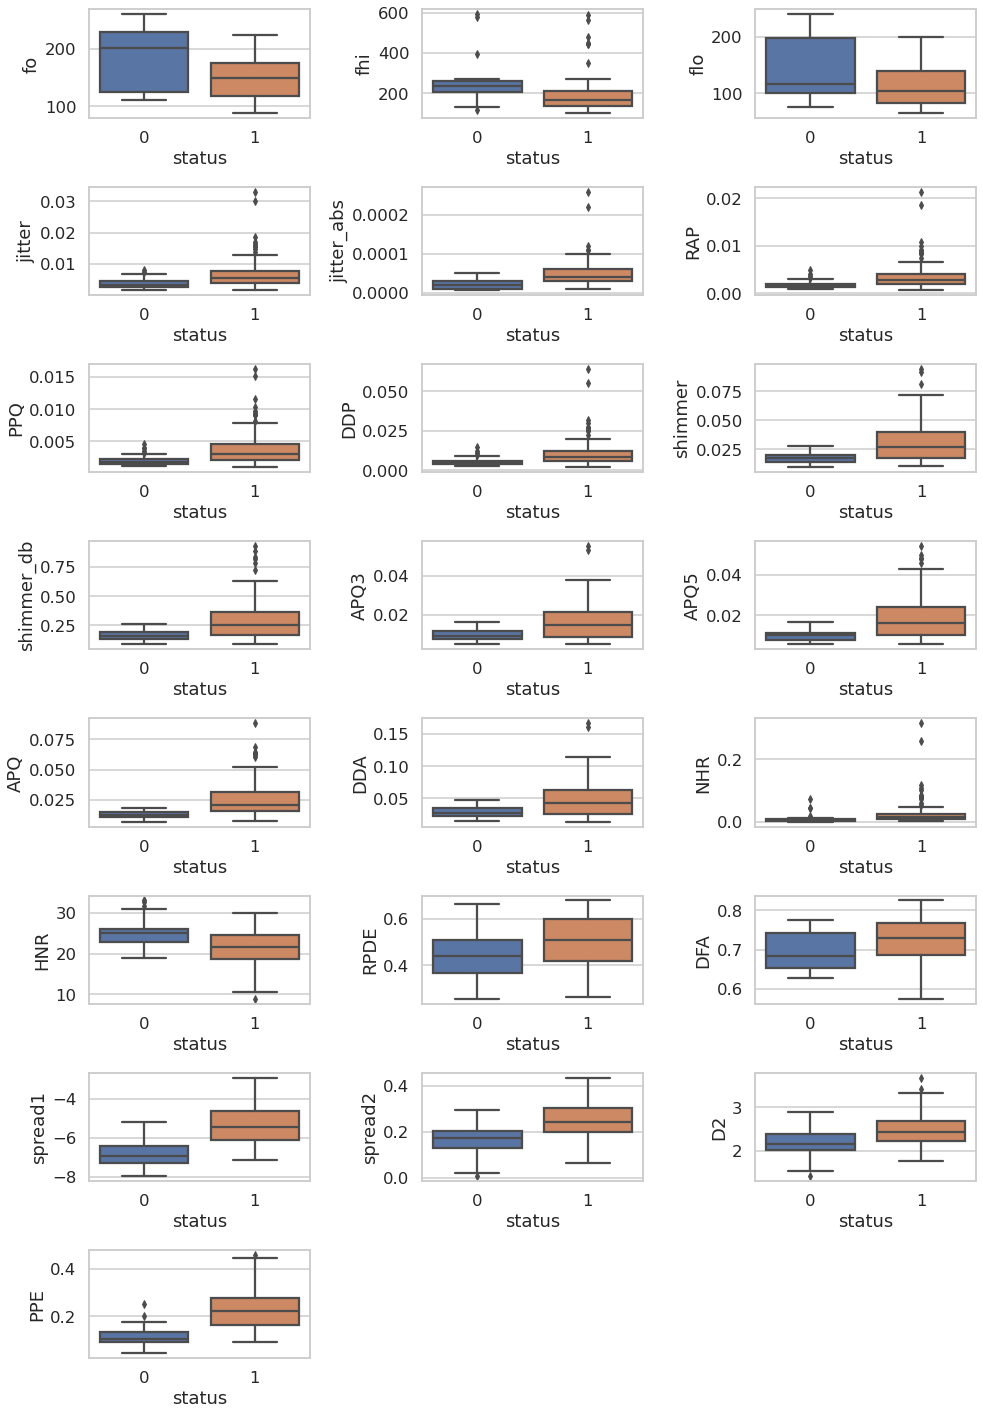

In [105]:
def boxplots_eda(data):
    fig, ax = plt.subplots(8, 3, figsize=(14, 20))
    ax = ax.flatten()
    ax[-1].set_axis_off()
    ax[-2].set_axis_off()
    
    for ax,feature in zip(ax,features):
        ax = sns.boxplot(ax=ax, x='status', y=feature, data=data)
        plt.tight_layout()
                
boxplots_eda(Xy_train)

We plot boxplots segregrated by status feature and observe a lot of outliers

In [106]:
train_df0 = Xy_train[features].loc[Xy_train['status'] == 0]
train_df1 = Xy_train[features].loc[Xy_train['status'] == 1]
outlier_list0 = []
outlier_list1 = []
outlier_list_tot = []

# Function for calculating IQR

def iqr(data):
    q25, q75 = np.percentile(data, [25,75], axis=0)
    iqr = q75 - q25
    min = q25 - 1.5 *(iqr)
    max = q75 + 1.5 *(iqr)
    return min,max

# Funtion for finding outliers in dataset  using  IQR

def outlier_list(data,out_list, feature = features):
    min,max = iqr(data)
    co = 0
    for coln in feature:
        out_list.append(len([x for x in data[coln] if x > max[co] or x < min[co]]))
        outlier_list_tot.append([[x, coln] for x in data[coln] if x > max[co] or x < min[co]])
        co += 1
    return out_list

outlier_df = pd.DataFrame([outlier_list(train_df0,outlier_list0), outlier_list(train_df1,outlier_list1)], 
                          columns = features, index = outcome).T

print(outlier_df)
print(f"\nTotal Outliers: \n{outlier_df.sum()}")

            Healthy  PD
fo                0   0
fhi               4   7
flo               0   0
jitter            2   9
jitter_abs        0   5
RAP               4  10
PPQ               5   9
DDP               4  10
shimmer           0   3
shimmer_db        0   6
APQ3              0   2
APQ5              0   5
APQ               0   7
DDA               0   2
NHR               4  13
HNR               3   1
RPDE              0   0
DFA               0   0
spread1           0   0
spread2           1   0
D2                1   2
PPE               2   1

Total Outliers: 
Healthy    30
PD         92
dtype: int64


List of total outliers found by IQR method, for all features segregrated 'status' wise.

We use IQR method as our data is skewed, not normally distributed and also is a more stable approach in comparison to 'Z' test for outliers which gets further affected by presence of outliers.

------------
# Transforming the data
----------

# Boxcox Transformation

In [107]:
lambda_box = []
for cols in skew_cols_name:
    data_box = stats.boxcox(Xy_train[cols])
    Xy_train[cols] = data_box[0]
    lambda_box.append(data_box[1])  
lambda_box

[-0.0679254357559945,
 -0.30898801068626996,
 -0.30852966507970203,
 -0.2983766825976761,
 0.032657940285325815,
 -0.3840202492484938,
 -0.9421927764300123,
 -0.4192044537727927,
 -0.38178702953857974,
 -0.245660701555137,
 -0.24579090074319263,
 -0.363987174034835,
 -0.3987102764400134,
 -0.7937177980433449]

We applied boxcox on training dataset, as all our features with outliers had positive values and some close to 0 making it more suitable than log transformation. Boxcox will help us in fixing the outliers and also making our dataset more normal improving our prediction and also making our algorithms run faster.

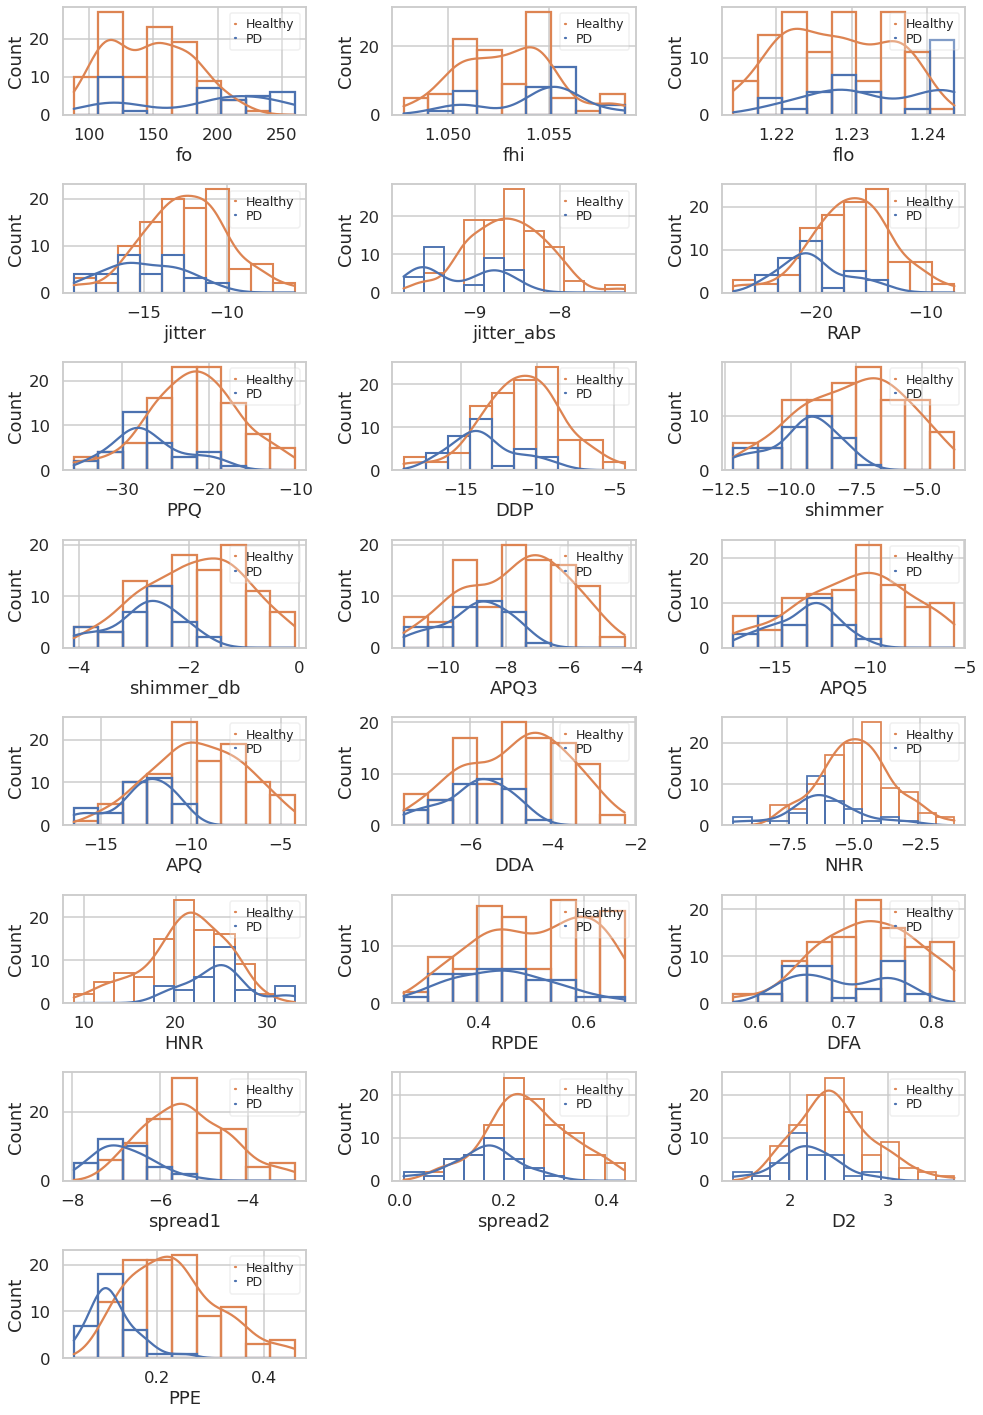

In [108]:
# Histogram after transformation
histogram_eda(Xy_train)

After boxcox transformation, we note from our plots of histogram that the data has become more normal,
although some features are still bimodel.

In [109]:
# Checking skewness after transformation

skew_vals1 = Xy_train[features].skew()
skew_cols1 = skew_vals1[abs(skew_vals1)>skew_limit].sort_values(ascending = False)
skew_cols1

Series([], dtype: float64)

The same is confirmed by skewtest, and thus no features have skewness more than 0.75 now

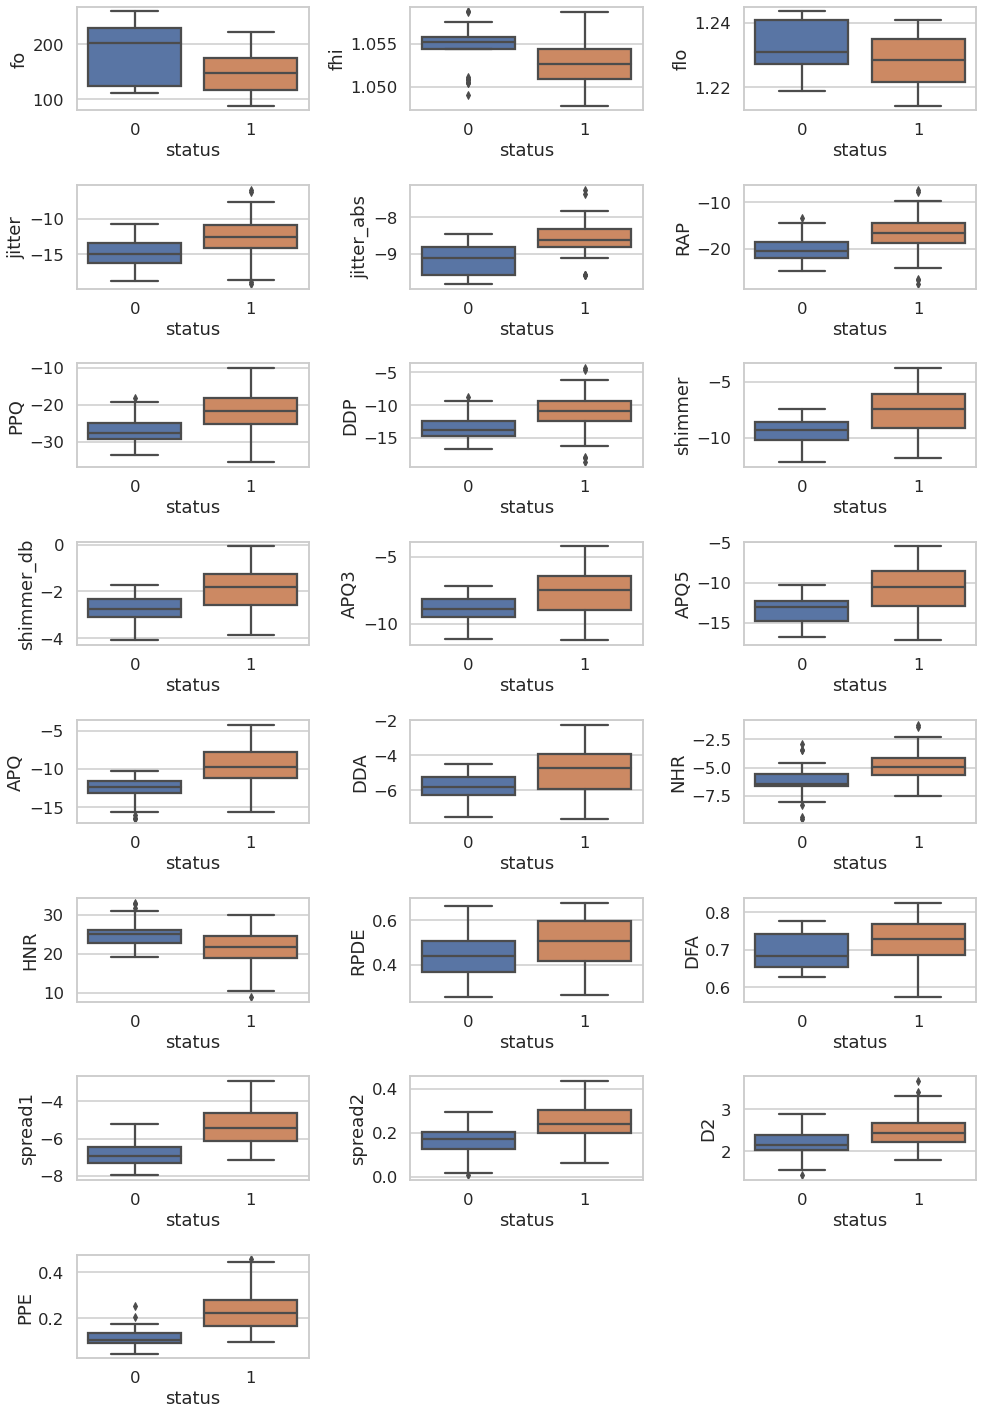

In [110]:
# Boxplot after transformation

boxplots_eda(Xy_train)        

After boxcox transformation, we note from our plots of boxplots that the number of outliers has reduced.

In [111]:
train_df0 = Xy_train[features].loc[Xy_train['status'] == 0]
train_df1 = Xy_train[features].loc[Xy_train['status'] == 1]

outlier_list0 = []
outlier_list1 = []
outlier_list_tot = []

box_df = pd.DataFrame([outlier_list(train_df0,outlier_list0), outlier_list(train_df1,outlier_list1)], columns = features, index = outcome).T

print(box_df)
print(f"\n{box_df.sum()}")

            Healthy  PD
fo                0   0
fhi              10   0
flo               0   0
jitter            0   4
jitter_abs        0   7
RAP               1   5
PPQ               1   0
DDP               1   5
shimmer           0   0
shimmer_db        0   0
APQ3              0   0
APQ5              0   0
APQ               3   0
DDA               0   0
NHR               6   2
HNR               3   1
RPDE              0   0
DFA               0   0
spread1           0   0
spread2           1   0
D2                1   2
PPE               2   1

Healthy    29
PD         27
dtype: int64


In [112]:
# List of outliers remaining

outlier_list_tot = [x for x in outlier_list_tot if x]
count = sum([len(listElem) for listElem in outlier_list_tot])
print(f"Total Number of outliers: {count}")

Total Number of outliers: 56


The total number of outliers have reduced more than half after boxcox transformation from 122 to 56

------------
# Multiple Imputation for Outliers
------------------

Unnecessary outliers(especially extreme outliers) can greatly affect correlation in a data set. They can also affect the prediction and speed of algorithms. At the same time, removing outliers without justification can increase biasness and might not reflect the real world data and our prediction can get affected in future. Thus, subject matter expert advice is definitely required in assessing them before taking any action on them.

Here, we assume the outliers are discrepancies in our dataset caused due to factors such as excessive use of speech before recording, time of day varying when recording, any other disease not observed/recorded affecting larynx box etc. Also note there is no information regarding sex, age and their proportion.

As our dataset is small, we will use multiple imputation technique instead of removing outliers as it will be more suitable and appropriate in comparison to other methods.

In [113]:
## Making remaining outliers to Nan (missing)

min,max = iqr(train_df0)
train_df0.iloc[((train_df0 > max) | (train_df0 < min))] = np.nan
min,max = iqr(train_df1)
train_df1.iloc[((train_df1 > max) | (train_df1 < min))] = np.nan

In [114]:
# Checking for outliers 

outlier_list0 = []
outlier_list1 = []

outlier_df = pd.DataFrame([outlier_list(train_df0,outlier_list0), outlier_list(train_df1,outlier_list1)], 
                          columns = features,index = outcome).T
outlier_df.sum()

Healthy    0
PD         0
dtype: int64

In [115]:
### Multiple Imputation for remaining outliers (converted to Nan)

imputer = IterativeImputer()
imputer.fit(train_df0)
data_imputed0 = imputer.transform(train_df0)
imputer.fit(train_df1)
data_imputed1 = imputer.transform(train_df1)
imputed_df0 = pd.DataFrame(data_imputed0, columns = features)
imputed_df1 = pd.DataFrame(data_imputed1, columns = features)

In [116]:
## Checking for outliers after multiple imputation

outlier_list0 = []
outlier_list1 = []
outlier_list_tot = []

outlier_df = pd.DataFrame([outlier_list(imputed_df0,outlier_list0), outlier_list(imputed_df1,outlier_list1)], columns = features,index = outcome).T

print(outlier_df)

outlier_list_tot = [x for x in outlier_list_tot if x]
total_out = sum([len(elem_list) for elem_list in outlier_list_tot])

print(f"\n Total no of Outliers left : {total_out}")

            Healthy  PD
fo                0   0
fhi               0   0
flo               0   0
jitter            0   0
jitter_abs        0   1
RAP               4   0
PPQ               0   0
DDP               4   0
shimmer           0   0
shimmer_db        0   0
APQ3              0   0
APQ5              0   0
APQ               3   0
DDA               0   0
NHR               0   2
HNR               0   0
RPDE              0   0
DFA               0   0
spread1           0   0
spread2           0   0
D2                1   0
PPE               0   0

 Total no of Outliers left : 15


After multiple imputation, we note we have further reduced our total nummber outliers from 56 to just 15

In [117]:
imputed_df0['status'] = 0
imputed_df1['status'] = 1
imputed_df = pd.concat([imputed_df0, imputed_df1])

#imputed_df['status'] = pd.to_numeric(imputed_df["status"])

print(f"{imputed_df.shape} \n")

imputed_df.head()

(136, 23) 



,fo,fhi,flo,jitter,jitter_abs,RAP,PPQ,DDP,shimmer,shimmer_db,...,DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,244.990,1.055962,1.243589,-13.443305,-9.114777,-16.656845,-23.929540,-10.951306,-8.885211,-2.410965,...,-5.372946,-5.341500,21.528,0.522812,0.646818,-7.304500,0.171088,2.095237,0.096220,0
1,237.226,1.055453,1.242793,-15.653629,-9.596126,-19.985240,-26.761237,-13.328322,-9.226808,-2.603994,...,-5.482347,-5.822728,22.736,0.305062,0.654172,-7.310550,0.098648,2.416838,0.095032,0
2,214.289,1.055730,1.220205,-12.334580,-8.828113,-16.317433,-21.125533,-10.708942,-8.914363,-2.318628,...,-5.502108,-5.128575,21.209,0.462803,0.664357,-5.724056,0.190667,2.555477,0.148569,0
3,209.516,1.055578,1.224315,-12.359429,-8.828113,-15.634809,-21.886050,-10.217336,-7.413250,-1.742202,...,-4.506932,-4.611698,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895,0
4,260.105,1.055823,1.243487,-14.936520,-9.596126,-18.641815,-26.517099,-12.361000,-8.601809,-2.250890,...,-5.167943,-5.536161,21.083,0.440988,0.628058,-7.517934,0.160414,1.881767,0.075587,0


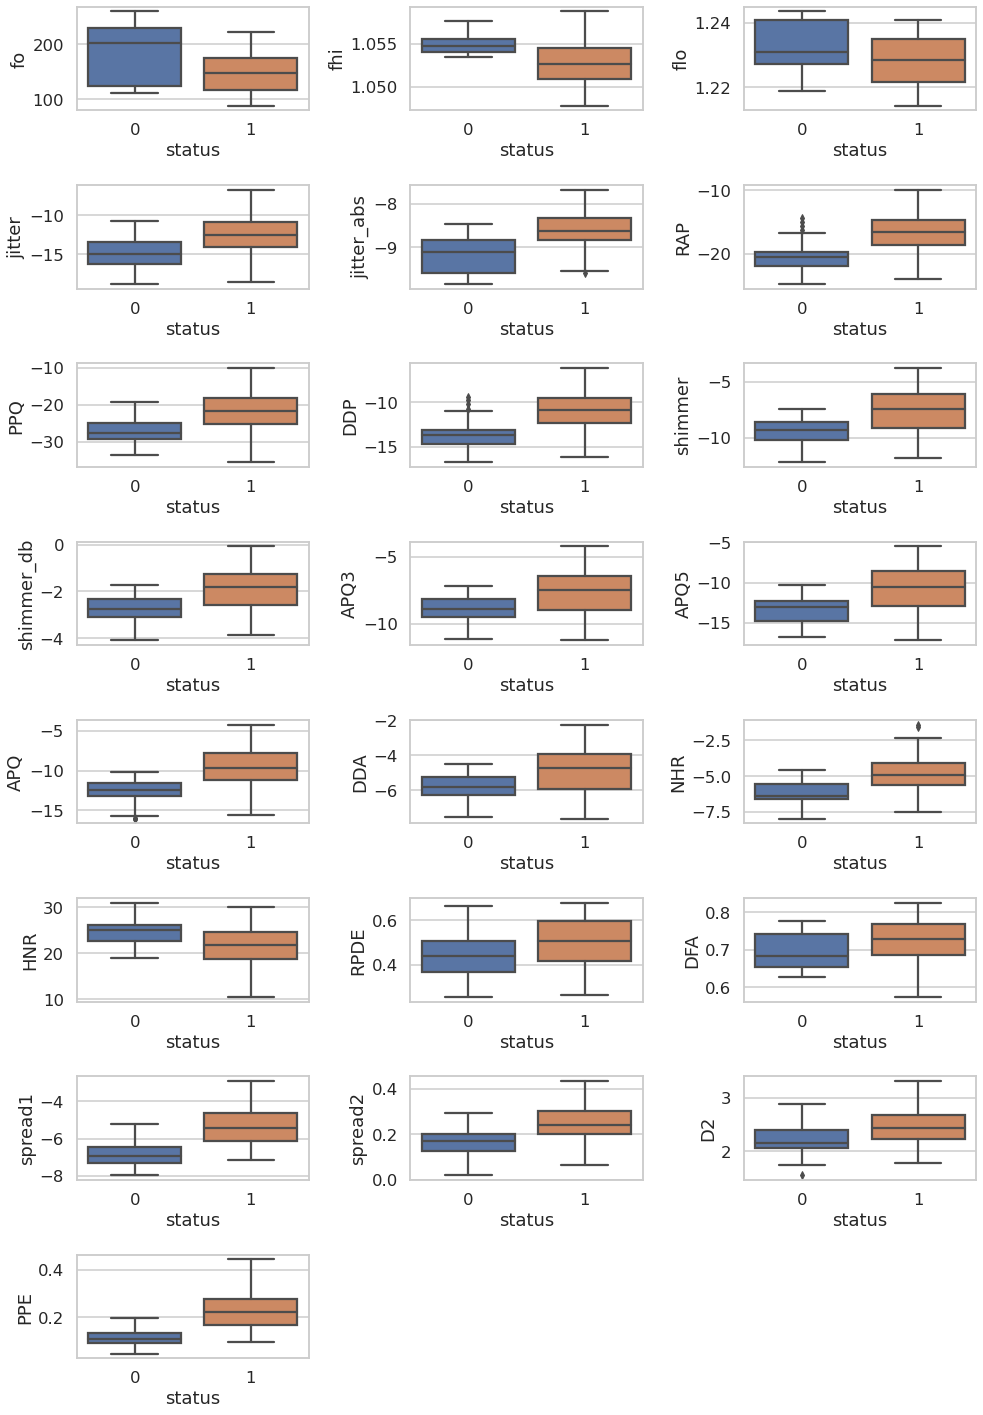

In [118]:
boxplots_eda(imputed_df)      

Boxplot after multiple imputation showing us graphically where remaining outliers are left

--------
# Correlation of Variables
----------

After treatment of outliers, we can finally check for correlation as they are also affected by it and remove highly correlated features. Although we are not considered with interpretability of the model, we remove highly correlated features to increase speed and for reducing storage(curse of dimensionality). Also they might incresae harmful bias in some algorithms like  Random Forest,KNN so we remove to reduce their signal-to-noise ratio.

In [119]:
print(abs(imputed_df.corrwith(imputed_df['status'])).sort_values(ascending = False))

status        1.000000
spread1       0.573532
PPE           0.565986
jitter_abs    0.493588
APQ           0.487600
DDP           0.472074
RAP           0.471920
spread2       0.427814
PPQ           0.425851
shimmer_db    0.417462
fo            0.416613
shimmer       0.407720
NHR           0.406110
jitter        0.405936
APQ5          0.392764
fhi           0.372153
DDA           0.350076
APQ3          0.350063
HNR           0.335460
D2            0.309466
flo           0.305451
RPDE          0.249332
DFA           0.226711
dtype: float64


We see the strength of correlation of 'status'(response varibale) to features(explanatory variables)

# Correlation Plot of Variables - Heatmap

We plot heatmap of features having  correlation with respect to 'status' in descending order.
Thus we can remove features having high correlation amongst other features and lowest correlation with status. 
We remove those features having more than 0.85 correlation with other features except 'status'(outcome variable).

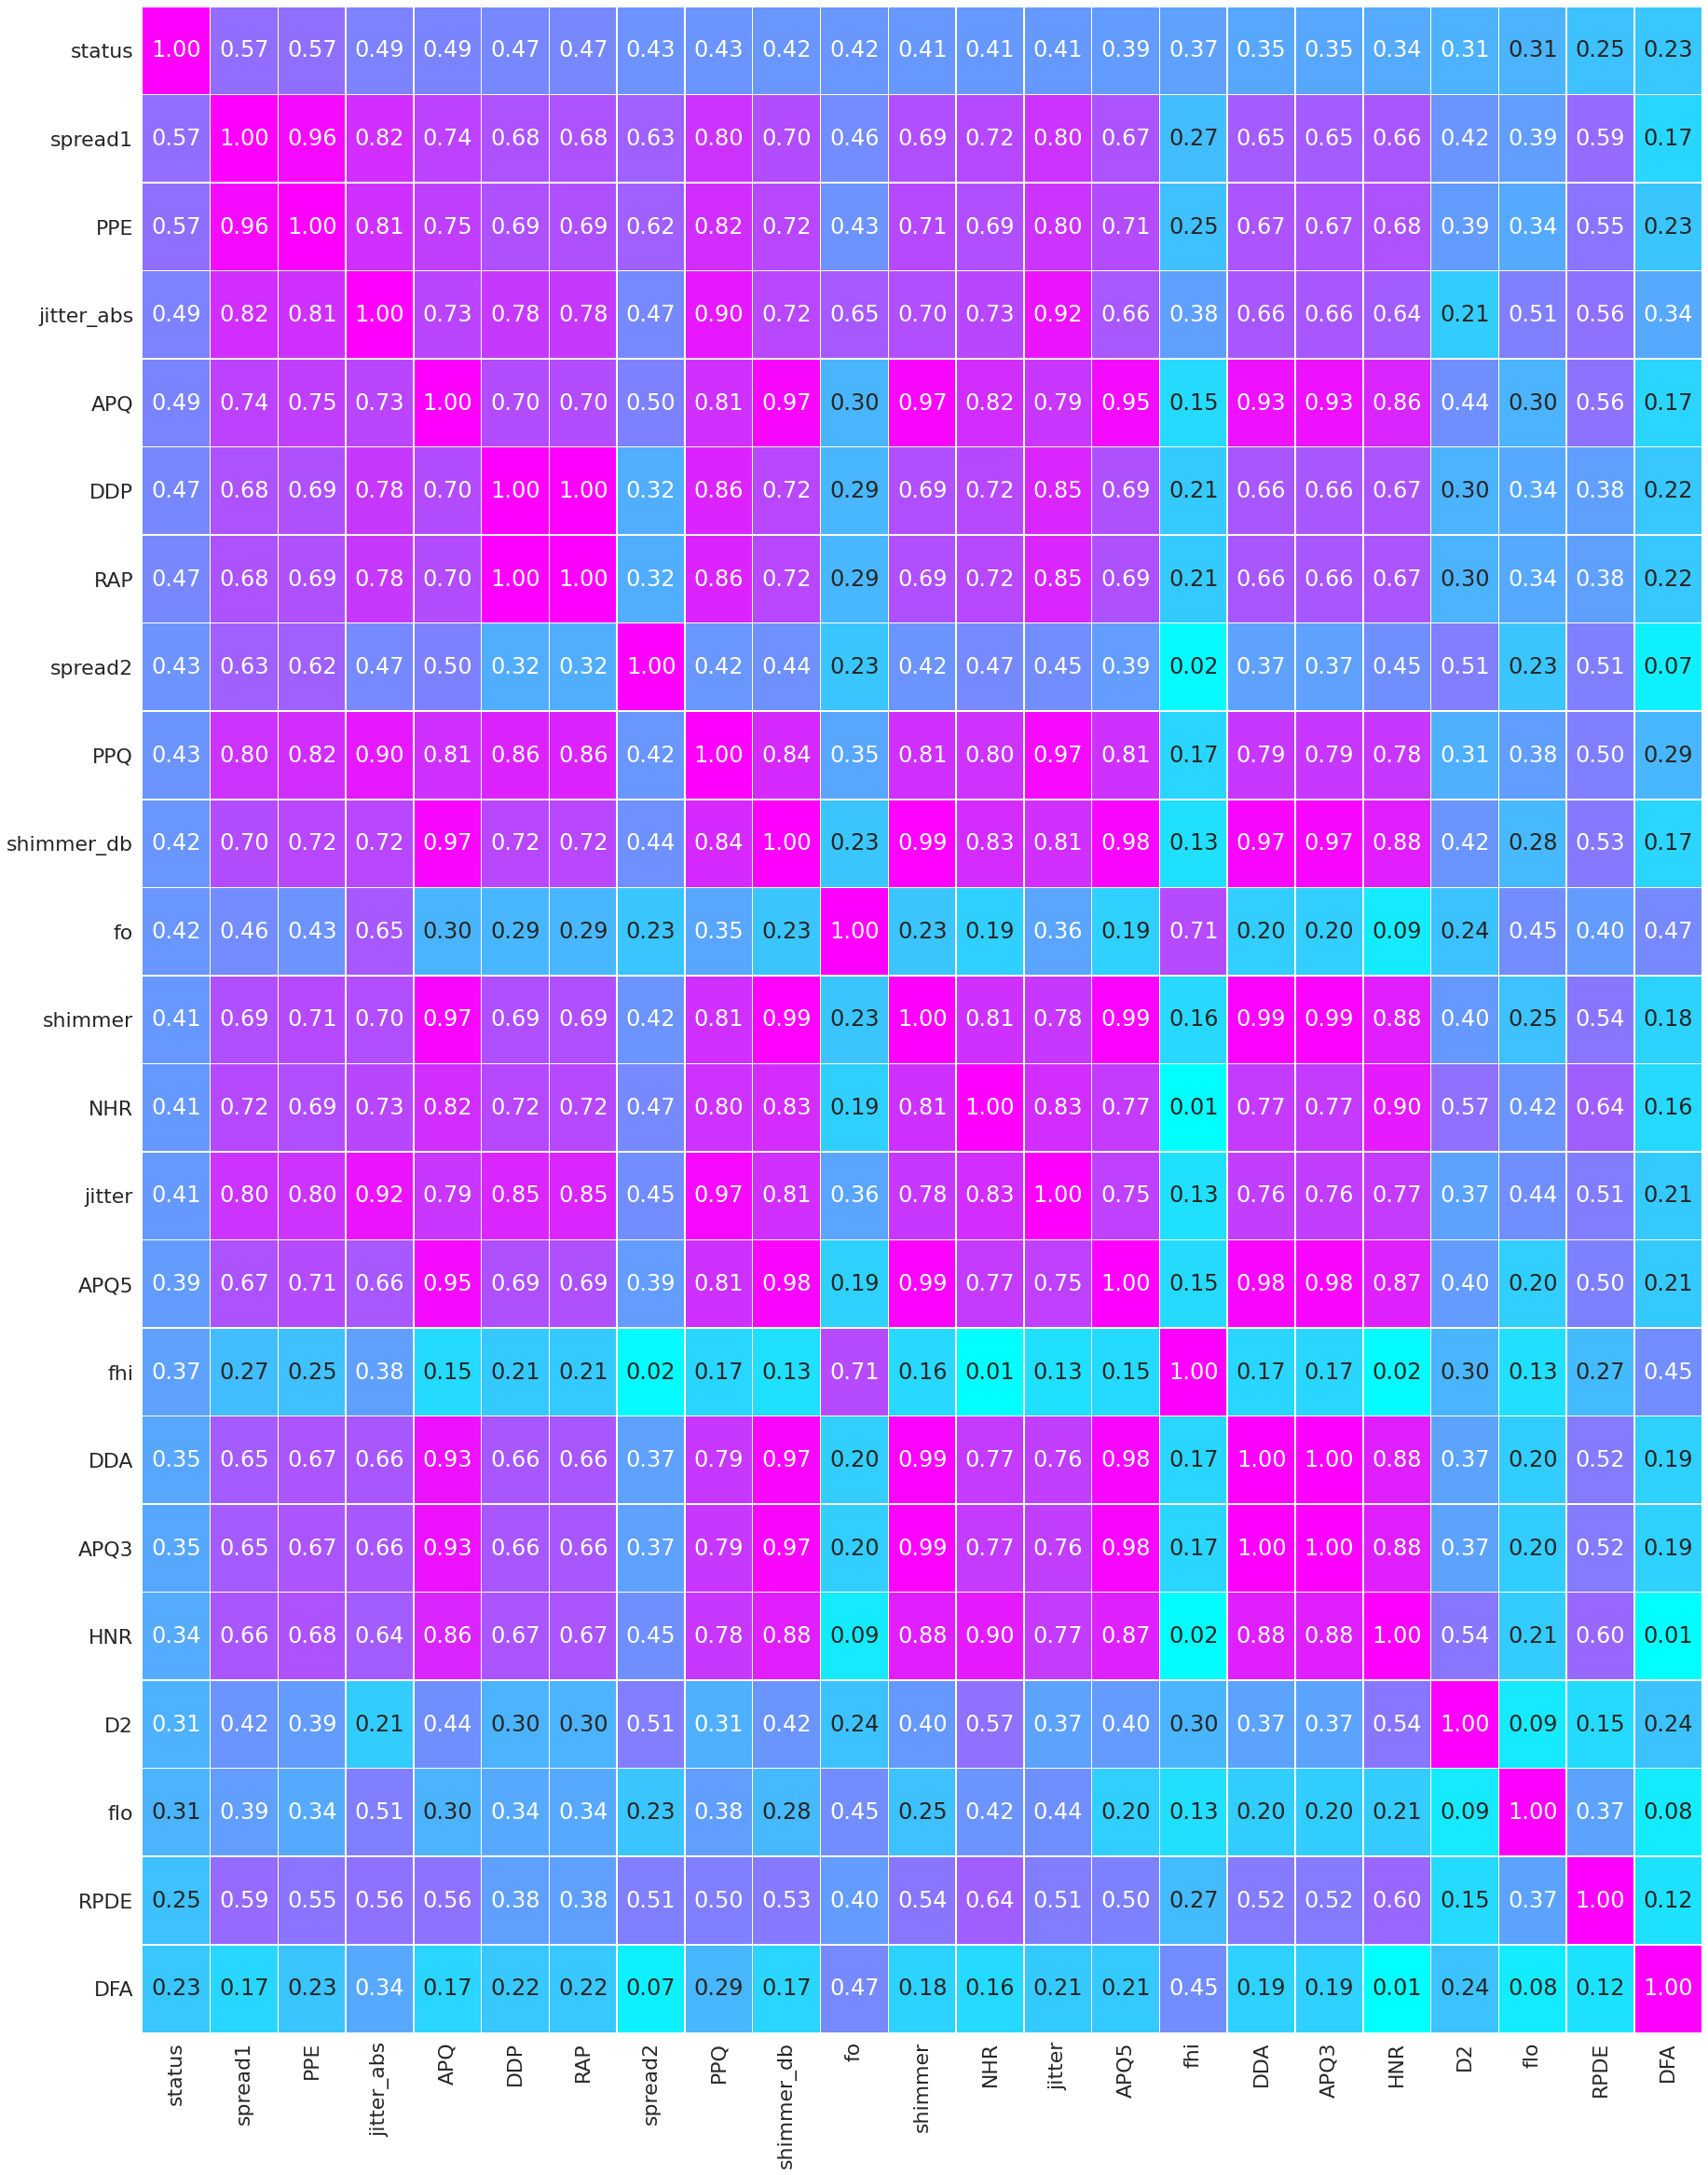

In [120]:
plt.figure(figsize = (30, 40))
sns.set(font_scale=2)

# We use abs to see aximum value of correlation with status (+ or -) 
corr_map = abs(imputed_df.corr())
corr_cols = corr_map.nlargest(24,'status')['status'].index
coff_val = np.corrcoef(imputed_df[corr_cols].values.T)
sns.heatmap(abs(coff_val), annot = True, cbar = False, linewidths=.5, cmap = plt.cm.cool,fmt='.2f', 
            xticklabels = corr_cols.values,yticklabels = corr_cols.values)
plt.show()

In [121]:
imputed_df.drop(["HNR", "DDA","APQ3","RAP","APQ5","shimmer", "shimmer_db","PPQ","jitter","spread1"],
                axis = 1, inplace = True)

imputed_df.shape

(136, 13)

We have dropped 10 highly correlated columns thus reducing dataset to 13 columns from 23

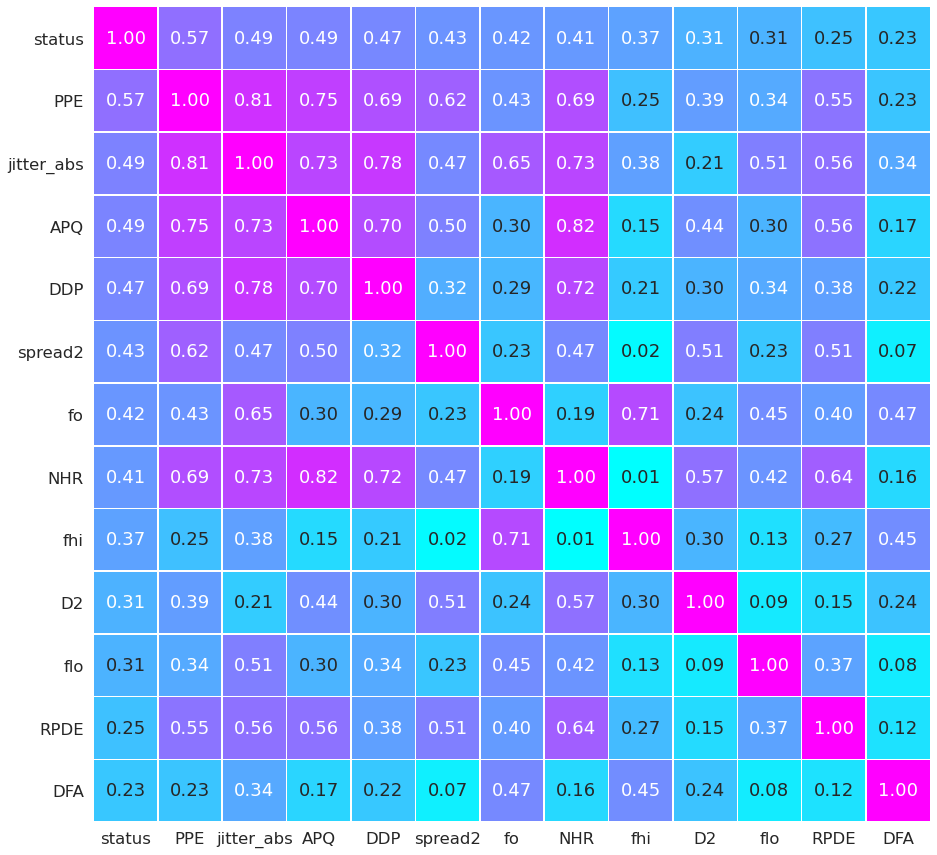

In [122]:
plt.figure(figsize = (15, 15))
sns.set(font_scale=1.5)

# We use abs to see aximum value of correlation with status (+ or -) 
corr_map = abs(imputed_df.corr())
corr_cols = corr_map.nlargest(24,'status')['status'].index
coff_val = np.corrcoef(imputed_df[corr_cols].values.T)
sns.heatmap(abs(coff_val), annot = True, cbar = False, linewidths=.5, cmap = plt.cm.cool,fmt='.2f', 
            xticklabels = corr_cols.values,yticklabels = corr_cols.values)
plt.show()

We can see correaltion heatmap after removing features having high correlation of 0.85 correlation with other explanatory variables and low correlation to response variable.

In [123]:
sel_features = imputed_df.columns.values

imputed_df0 = imputed_df[sel_features].loc[imputed_df['status'] == 0]
imputed_df1 = imputed_df[sel_features].loc[imputed_df['status'] == 1]
outlier_list0 = []
outlier_list1 = []

outlier_df = pd.DataFrame([outlier_list(imputed_df0,outlier_list0,sel_features),
                           outlier_list(imputed_df1,outlier_list1,sel_features)], 
                           columns = sel_features, index = outcome).T

print(outlier_df)

print(f"\nTotal Outliers: \n{outlier_df.sum()}")

            Healthy  PD
fo                0   0
fhi               0   0
flo               0   0
jitter_abs        0   1
DDP               4   0
APQ               3   0
NHR               0   2
RPDE              0   0
DFA               0   0
spread2           0   0
D2                1   0
PPE               0   0
status            0   0

Total Outliers: 
Healthy    8
PD         3
dtype: int64


In [129]:
print(f"Max% of outliers in a column for the whole dataset : {round((outlier_df.loc['DDP','Healthy']/imputed_df.shape[0])*100,2)}% in DDP" )
print(f"Max% of outliers in a column outcome wise : {round((outlier_df.loc[:,'Healthy'].count()/imputed_df.shape[0])*100,2)}% in DDP for PD column" )

Max% of outliers in a column for the whole dataset : 2.94% in DDP
Max% of outliers in a column outcome wise : 9.56% in DDP for PD column


After removing the correlated columns, our outliers are further reduced by 4, coming  down to 11 from 15

# Box Cox Transformation of Test Set

After finding and removing the correlated features, we can do boxcox transformation for our test data set as well.

We will use the lambda values from the train set onto our test set to transform them, taking caution not to cause any data leakage.

In [125]:
col = 0
for cols in skew_cols_name:
    data_box = stats.boxcox(Xy_test[cols], lambda_box[col])
    Xy_test[cols] = data_box
    col +=1

In [126]:
# Dropping same columns (correlated features) from test set data

Xy_test = Xy_test[sel_features]

Xy_test.shape

(59, 13)

We dropped the same number of columns (highly correlated features) from our test dataset and confirming our training and test dataset have same number of columns

In [127]:
Xy_test.head()

,fo,fhi,flo,jitter_abs,DDP,APQ,NHR,RPDE,DFA,spread2,D2,PPE,status
73,112.014,1.058746,1.229026,-8.461513,-11.123228,-10.026476,-6.064310,0.509127,0.789532,0.306636,1.928708,0.225461,1
169,240.301,1.055403,1.242457,-9.114777,-10.411309,-12.140912,-5.455571,0.371837,0.646167,0.073298,2.266432,0.100881,0
21,153.880,1.053084,1.220268,-8.828113,-11.783501,-6.347154,-4.583722,0.629017,0.698951,0.237622,2.557536,0.259765,1
175,115.380,1.049967,1.229390,-8.828113,-13.610801,-13.219020,-6.695783,0.405991,0.761255,0.197938,1.974857,0.184067,0
91,151.955,1.052630,1.235929,-8.828113,-11.947245,-5.547513,-4.727234,0.501037,0.714360,0.207156,2.344876,0.134120,1


In [128]:
## Saving after data wrangling, EDA and preprocessing of data.

outputfile_1 = 'parkinsons_train.csv'
outputfile_2 = 'parkinsons_test.csv'
imputed_df.to_csv(outputfile_1, index=False)
Xy_test.to_csv(outputfile_2, index=False)